<h1 style="text-align: center;">MODEL INTERPRETATION</h1>

### Import the libraries

In [2]:
import torch.nn as nn 
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt

from joblib import load

import shap
from captum.attr import IntegratedGradients
shap.initjs()

import os
import warnings
warnings.filterwarnings("ignore")

### Load the Data

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/mlp-parameters/mlp_parameters_tensor.pth
/kaggle/input/serialized-uti-dataset/preprocessed_unscaled_data.joblib
/kaggle/input/serialized-uti-dataset/preprocessed_data.joblib


In [4]:
X_train_unscaled, X_test_unscaled, y_train, y_test = load(r"/kaggle/input/serialized-uti-dataset/preprocessed_data.joblib")

### Load the Model

In [5]:
class ClassifierNN(nn.Module):
    """
    Neural network classifier.

    Parameters
    ----------
    activation_function : torch.nn.Module
        The activation function to be used in the network.

    Attributes
    ----------
    activation_function : torch.nn.Module
        The activation function for the network.
    fcn1 : torch.nn.Linear
        The first fully connected layer with input size 14 and output size 32.
    fcn2 : torch.nn.Linear
        The second fully connected layer with input size 32 and output size 64.
    fcn3 : torch.nn.Linear
        The third fully connected layer with input size 64 and output size 128.
    fcn4 : torch.nn.Linear
        The fourth fully connected layer with input size 128 and output size 2.

    Methods
    -------
    forward(x)
        Forward pass of the neural network.

    """

    def __init__(self):
        super().__init__()
        optimal_activation_function = F.relu

        self.activation_function = optimal_activation_function

        # Define fully connected layers
        self.fcn1 = nn.Linear(14, 32)
        self.fcn2 = nn.Linear(32, 64)
        self.fcn3 = nn.Linear(64, 128)
        self.fcn4 = nn.Linear(128, 2)

    def forward(self, x):
        """
        Forward pass of the neural network.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor with shape (-1, 14).

        Returns
        -------
        torch.Tensor
            Output tensor after the forward pass.
        """
        x = x.view(-1, 14)

        x = self.activation_function(self.fcn1(x))
        x = self.activation_function(self.fcn2(x))
        x = self.activation_function(self.fcn3(x))

        x = self.fcn4(x)

        return x

In [6]:
best_model = ClassifierNN()

best_model.load_state_dict(torch.load(r"/kaggle/input/mlp-parameters/mlp_parameters_tensor.pth"))

<All keys matched successfully>

In [7]:
best_model.eval()

ClassifierNN(
  (fcn1): Linear(in_features=14, out_features=32, bias=True)
  (fcn2): Linear(in_features=32, out_features=64, bias=True)
  (fcn3): Linear(in_features=64, out_features=128, bias=True)
  (fcn4): Linear(in_features=128, out_features=2, bias=True)
)

### Local Interpretability (Integrated Gradient Analysis)

In [8]:
def integrated_gradients_analysis(model, input_data, label, feature_names):    
    input_tensor = torch.from_numpy(input_data.to_numpy(dtype="float32")).float().unsqueeze(0)

    target_tensor = torch.tensor(label, dtype=torch.long)
    baseline_tensor = torch.zeros_like(input_tensor)

    integrated_gradients  = IntegratedGradients(model)
    attribution = integrated_gradients .attribute(input_tensor, target=target_tensor, n_steps=50, baselines=baseline_tensor)

    # Convert attribution tensor to numpy array
    attribution_np = attribution.squeeze(0).detach().numpy()

    return attribution_np

In [20]:
# Sample data to use for local interpretability
sample_index = -1
input_data = X_test_unscaled.iloc[sample_index]
label = y_test.to_list()[sample_index]

In [10]:
input_data

Age                 0.163043
Color               0.714286
Transparency             0.0
Glucose                  0.0
Protein                  0.0
pH                  0.333333
Specific Gravity         0.2
WBC                     0.75
RBC                      0.0
Epithelial Cells         0.0
Mucous Threads           0.0
Amorphous Urates         0.0
Bacteria                 0.6
FEMALE                 False
Name: 430, dtype: object

In [11]:
label

1

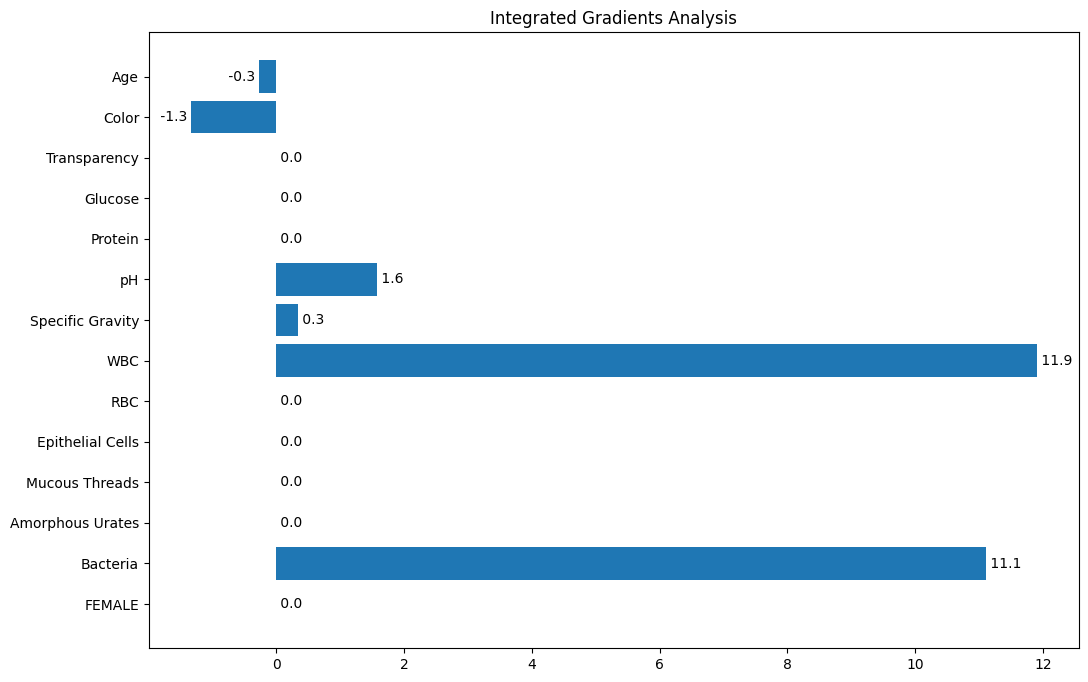

In [22]:
attribution_map = integrated_gradients_analysis(best_model, input_data, label, X_train_unscaled.columns)

fig, axes = plt.subplots(figsize=(12, 8))

bar_graph = axes.barh(X_train_unscaled.columns, attribution_map)

container = axes.containers[0]
axes.bar_label(bar_graph, labels=[f' {x:,.1f} ' for x in container.datavalues])

axes.set_title('Integrated Gradients Analysis')
axes.invert_yaxis()
plt.show()

In [13]:
# Convert boolean values to integers in the "FEMALE" column of X_train_unscaled
X_train_unscaled["FEMALE"] = [1 if bool_ else 0 for bool_ in X_train_unscaled["FEMALE"]]

# Convert boolean values to integers in the "FEMALE" column of X_test_unscaled
X_test_unscaled["FEMALE"] = [1 if bool_ else 0 for bool_ in X_test_unscaled["FEMALE"]]

In [14]:
input_data = X_test_unscaled.values.astype('float32')
input_tensor = torch.tensor(input_data)

In [15]:
explainer = shap.DeepExplainer(best_model, input_tensor)

In [16]:
shap_values = explainer.shap_values(input_tensor, check_additivity=False)

### Local Interpretability (SHAP)

In [17]:
shap.force_plot(explainer.expected_value[1], shap_values[1][sample_index], X_train_unscaled.columns)

### Global Interpretability (SHAP)

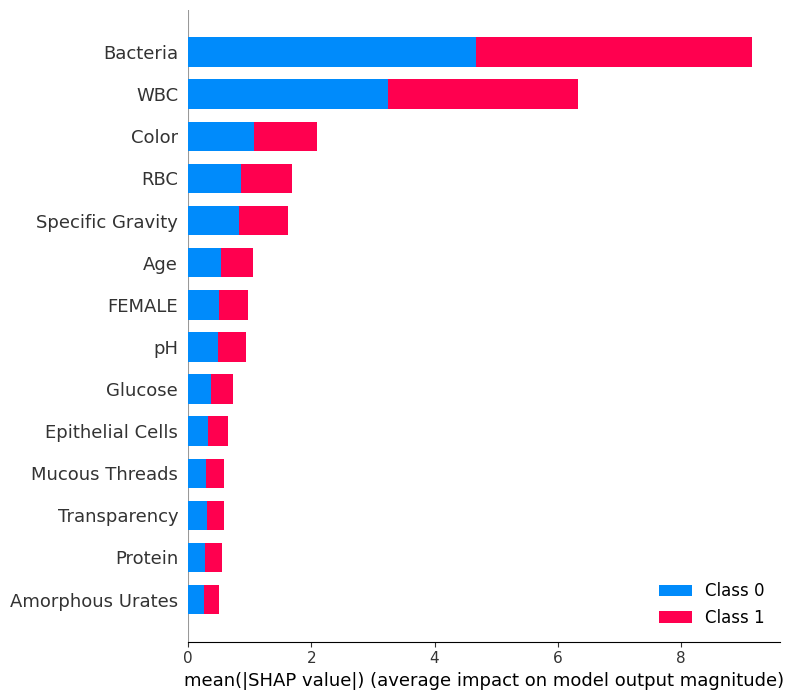

In [18]:
# selecting the first array from the variable values. values[1] = POSITIVE classification
shap.summary_plot(shap_values, X_test_unscaled)